# Implement a hierarchical continuous-discrete Variational Autoencoder

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook
import librosa
import librosa.display
from scipy.misc import imsave
import errno
from keras.preprocessing.image import load_img, img_to_array
from tensorflow import layers
from tensorflow.contrib import distributions as dist
from tensorflow.contrib import slim
from sklearn.decomposition import PCA 

Using TensorFlow backend.


In [2]:
parentdir = os.getcwd()

metadata = pd.read_csv(os.path.join(parentdir, 'UrbanSound8K/metadata/UrbanSound8K.csv'))
metadata.drop_duplicates('class')

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn
22,100852-0-0-0.wav,100852,0.000000,4.000000,1,5,0,air_conditioner
94,101848-9-0-0.wav,101848,0.000000,4.000000,1,7,9,street_music
106,102305-6-0-0.wav,102305,0.000000,2.611610,1,1,6,gun_shot
114,102853-8-0-0.wav,102853,0.000000,4.000000,2,7,8,siren
122,102857-5-0-0.wav,102857,0.000000,4.000000,1,10,5,engine_idling
171,103074-7-0-0.wav,103074,3.341279,7.341279,1,1,7,jackhammer
196,103199-4-0-0.wav,103199,0.000000,4.000000,1,3,4,drilling


Find the distributions of the classes (How balanced is the dataset)

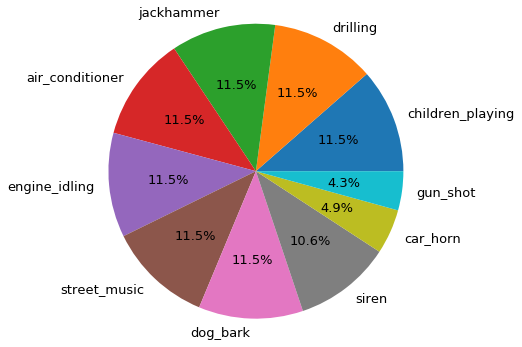

In [3]:
metadata['class'].value_counts().plot(kind='pie', 
                                  figsize=(8,6), 
                                  fontsize=13, 
                                  autopct='%1.1f%%', 
                                  wedgeprops={'linewidth': 5}
                                  )
plt.axis('off')
plt.axis('equal')
plt.show()

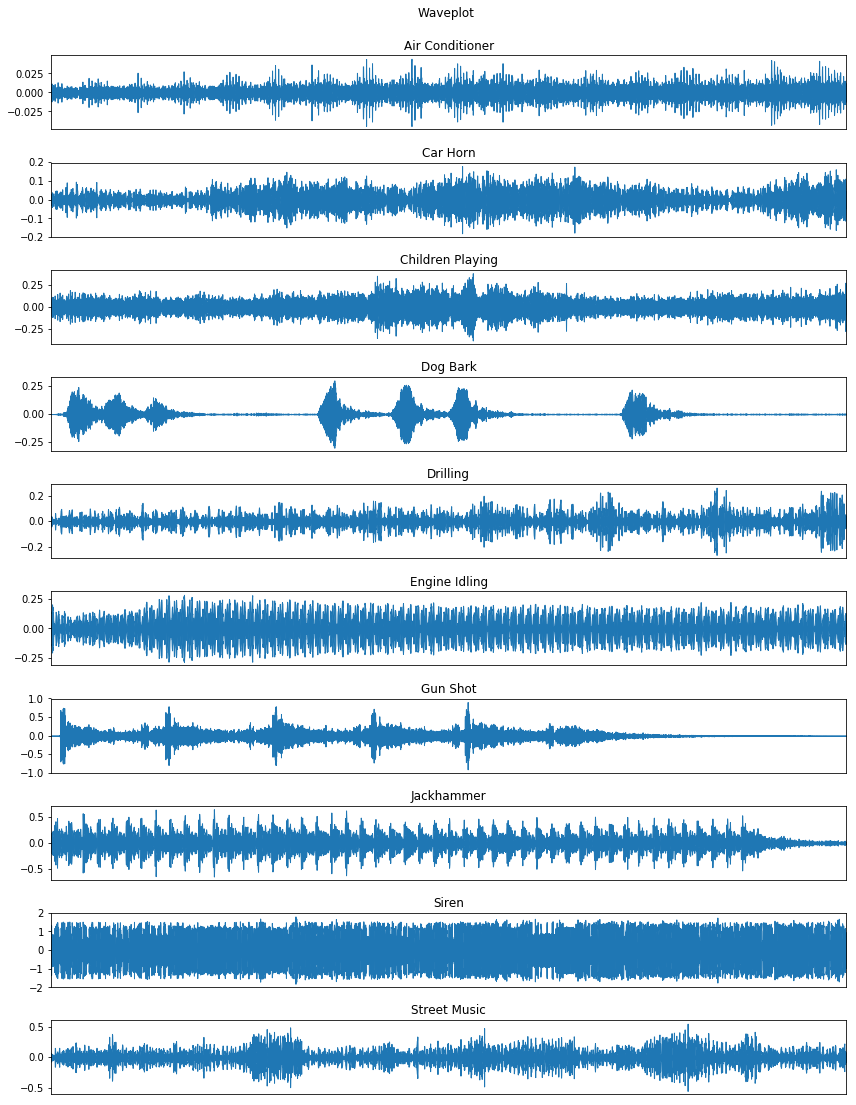

In [4]:
# path to dataset
sound_dir = os.path.join(parentdir)

# choosing one sound from each category
unique_sounds = ["14113-4-0-1.wav","24074-1-0-0.wav","15564-2-0-1.wav","7383-3-0-0.wav",
                 "57320-0-0-4.wav","17592-5-1-0.wav","7061-6-0-0.wav", 
                 "98223-7-0-0.wav","40722-8-0-0.wav","21684-9-0-5.wav"]
sound_names = ["air conditioner", "car horn", "children playing", "dog bark", 
               "drilling", "engine idling", "gun shot", 
               "jackhammer", "siren", "street music"]

# raw time-series values for these sounds
raw = []
for u in unique_sounds:
    ts, sr = librosa.load(os.path.join(sound_dir, u))
    raw.append(ts)

# waveplot of unique sound-classes within dataset
def waves(raw_sounds):    
    i = 1
    fig = plt.figure(figsize=(12,15))
    for file,name in zip(raw_sounds,sound_names):
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(file), x_axis=None)
        plt.title(name.title())
        i += 1
    plt.suptitle("Waveplot", x=0.52, y=1.02, fontsize=12)
    fig.tight_layout()

waves(raw)

In [5]:
def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# Convert each wav file to spectrogram image

In [6]:
# N_FFT = 512
# HOP_LEN = N_FFT // 2
# SR = 16000
# fold_list = ['fold1', 'fold2', 'fold3', 'fold4', 'fold5', 'fold6', 'fold7', 'fold8', 'fold9', 'fold10']
# exception_count = 0
rows = 257
cols = 251

# oof = open('file_exceptions.txt', 'w') # redirect error exceptions for audio files

# target_spectrogram_folder_images = "UrbanSound8K/spectrograms"

# max_number_seconds = 4

# for i in range(10):
#     mypath = 'UrbanSound8K/audio/'+ fold_list[i] + '/'
#     files = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

#     make_sure_path_exists(target_spectrogram_folder_images + "/" + fold_list[i])

#     for f in tqdm_notebook(files):
#         fn = mypath + f
#         try: 
#             data, rate = librosa.load(fn, sr=SR, mono=True)

#             # Zero pad recordings that are less than 4 seconds
#             if data.shape[0] != SR*max_number_seconds:
#                 data = np.append(data, np.zeros((SR*max_number_seconds - data.shape[0], )))

#             X = librosa.stft(data, n_fft=N_FFT, hop_length=HOP_LEN)
#             D = librosa.amplitude_to_db(np.abs(X))
#             D = np.flipud(D)

#     #             plt.imshow(D, cmap='gray')
#     #             plt.show()
#             if D.shape[0] != rows or D.shape[1] != cols:
#                 print(audio_name, D.shape)

#             imsave(target_spectrogram_folder_images + "/" + fold_list[i] + "/" + f.split(".wav")[0] + '.png', D)

#         except Exception as e:
#             print(os.path.basename(os.path.normpath(fn)), file=oof)

# Convert spectrograms to NumPy arrays

In [7]:
def make_labels(data):
    
    # Extract target class from the filepath
    
    label = data.split('-')[1]
    return int(label)

In [8]:
# example = os.path.join(target_spectrogram_folder_images, "fold2", "14780-9-0-0.png")
# print("file path =", example)
# print('')
# print("label:", make_labels(example))

In [9]:
# for i in range(10):
#     spectrograms_array = []
#     labels = []
#     mypath = 'UrbanSound8K/spectrograms/'+ fold_list[i] + '/'
#     files = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]
    
#     for f in tqdm_notebook(files):
#         image_file = mypath + f
#         img = load_img(image_file, grayscale=True)
#         x = img_to_array(img)
#         x /= 255.
#         spectrograms_array.append(x)
#         labels.append(make_labels(image_file))
#     np.save("spectrograms_fold_{0}.npy".format(i+1), np.array(spectrograms_array))
#     np.save("labels_fold_{0}.npy".format(i+1), np.array(labels))
# print("\nAll images are converted to numpy arrays!")

# Start the Convolutional Variational Autoencoder !

In [10]:
X_train = np.load('spectrograms_fold_1.npy')
X_val = np.load('spectrograms_fold_2.npy')
y_train = np.load('labels_fold_1.npy')
y_val = np.load('labels_fold_2.npy')

print('Dataset sizes:')
print('X_train:', X_train.shape)
print('X_val:', X_val.shape)
print('y_train:', y_train.shape)
print('y_val:', y_val.shape)

Dataset sizes:
X_train: (873, 257, 251, 1)
X_val: (888, 257, 251, 1)
y_train: (873,)
y_val: (888,)


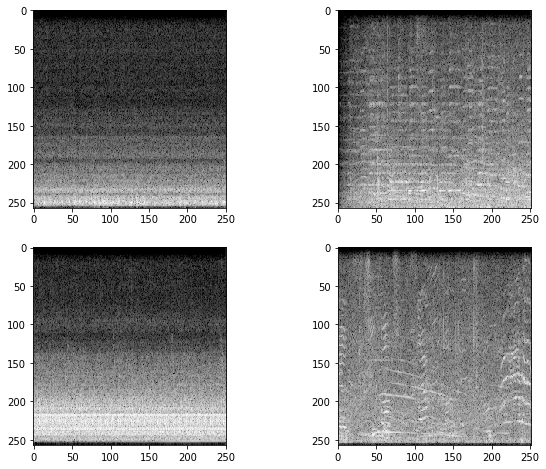

In [11]:
fig = plt.figure(figsize=(10,8))

for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow(np.reshape(X_train[i], (257, 251)), cmap='gray')

In [12]:
n_train_samples = X_train.shape[0]
n_valid_samples = X_val.shape[0]
n_classes = 10
y_train_one_hot = np.eye(n_classes)[y_train]
y_valid_one_hot = np.eye(n_classes)[y_val]

print(y_train_one_hot.shape)

(873, 10)


In [13]:
n_channels = 1
batch_size = 16
lr = 0.001
n_epochs = 10
n_train_batches = n_train_samples // batch_size
n_valid_batches = n_valid_samples // batch_size

In [14]:
X_placeholder = tf.placeholder(tf.float32, [None, rows, cols, n_channels])
y_placeholder = tf.placeholder(tf.float32, [None, n_classes])
# training = tf.placeholder(tf.bool)

input_layer = X_placeholder


conv1 = tf.layers.conv2d(inputs=input_layer,
                        filters=32,
                        kernel_size=[5,5],
                        padding="same",
                        activation=tf.nn.relu)

pool1 = tf.layers.max_pooling2d(inputs=conv1,
                               pool_size=[2,2],
                               strides=2)

conv2 = tf.layers.conv2d(inputs=pool1,
                        filters=32,
                        kernel_size=[5,5],
                        padding="same",
                        activation=tf.nn.relu)

pool2 = tf.layers.max_pooling2d(inputs=conv2,
                               pool_size=[2,2],
                               strides=2)

pool2_flat = tf.reshape(pool2, [-1, 64 * 62 * 64])

fully_connected = tf.layers.dense(inputs=pool2_flat,
                                 units=1024,
                                 activation=tf.nn.relu)

dropout = tf.layers.dropout(inputs=fully_connected,
                           rate=0.4)

logits = tf.layers.dense(inputs=dropout,
                        units=n_classes)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                                labels=y_placeholder))

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_placeholder,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for epoch in range(n_epochs):
        print()
        print("Epoch", epoch)
        
        for i in range(n_train_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            
            x_batch = X_train[start:end]
            y_batch = y_train_one_hot[start:end]
            _train_step, _loss = sess.run([train_step, loss],
                                        feed_dict=
                                        {X_placeholder:x_batch,
                                         y_placeholder:y_batch
                                        })
    
            
            if i % 100 == 0:
                _loss, _accuracy = sess.run([loss, accuracy],
                                 feed_dict={
                                     X_placeholder:x_batch,
                                     y_placeholder:y_batch
                                 })
                
                print("Minibatch loss:" , _loss)  
                print("Accuracy:", _accuracy)
          
    print()
    print("Optimization done! Let's calculate the test error")


Epoch 0


InvalidArgumentError: logits and labels must be broadcastable: logits_size=[8,10] labels_size=[16,10]
	 [[node softmax_cross_entropy_with_logits (defined at <ipython-input-14-91649d8bf120>:41)  = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/BiasAdd, softmax_cross_entropy_with_logits/Reshape_1)]]

Caused by op 'softmax_cross_entropy_with_logits', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/usr/local/lib/python3.5/dist-packages/tornado/ioloop.py", line 759, in _run_callback
    ret = callback()
  File "/usr/local/lib/python3.5/dist-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1199, in inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 370, in dispatch_queue
    yield self.process_one()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 335, in wrapper
    runner = Runner(result, future, yielded)
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1046, in __init__
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 1113, in run
    yielded = self.gen.send(value)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/usr/local/lib/python3.5/dist-packages/tornado/gen.py", line 315, in wrapper
    yielded = next(result)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-91649d8bf120>", line 41, in <module>
    labels=y_placeholder))
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_ops.py", line 1864, in softmax_cross_entropy_with_logits_v2
    precise_logits, labels, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 7210, in softmax_cross_entropy_with_logits
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): logits and labels must be broadcastable: logits_size=[8,10] labels_size=[16,10]
	 [[node softmax_cross_entropy_with_logits (defined at <ipython-input-14-91649d8bf120>:41)  = SoftmaxCrossEntropyWithLogits[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](dense_1/BiasAdd, softmax_cross_entropy_with_logits/Reshape_1)]]
